In [9]:
import pandas as pd
import os
import re
import numpy as np
import pickle

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, RepeatedKFold

from sklearn.metrics import f1_score, recall_score, make_scorer
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
sns.set_style('whitegrid')

path = r'C:\Users\chiar\Documents\Università\Text analytics\Data'
#path = r'D:\tirocinioLC\tirocinioLC'

Load dataset

In [10]:
df = pd.read_json(path+'\df_final.json')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37693 entries, 1 to 54718
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype              
---  ------   --------------  -----              
 0   ID       37693 non-null  int64              
 1   Title    37690 non-null  object             
 2   Rating   37693 non-null  object             
 3   Author   37693 non-null  object             
 4   Date     37693 non-null  datetime64[ns, UTC]
 5   Chapter  37693 non-null  int64              
 6   Text     37693 non-null  object             
 7   N_Rev    37693 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(3), object(4)
memory usage: 2.6+ MB
None


,ID,Title,Rating,Author,Date,Chapter,Text,N_Rev
1,2909917,Rilassati! Hai tutta la morte davanti!,verde,Tonks98,2014-11-15 00:00:00+00:00,1,"""Zi zieda, prego. Allora, quale ezzere zuo ""B...",3
4,1390250,Episodi della Old Generation 1.,verde,mrsreg,2012-11-17 00:00:00+00:00,1,Introduzione. Personaggi: Argus Gazza:...,0
5,1143283,In Noctem,verde,LilacLilium,2012-04-07 00:00:00+00:00,1,Questo mio piccolo lavoretto è ispirato a una ...,2
7,917615,Dirty flower.,verde,Rue,2012-07-01 00:00:00+00:00,1,"DIRTY FLOWER. Lo hai sempre saputo, Lily. ...",3
8,917635,Hawthorn and Unicorn Air,giallo,Tonna,2012-08-01 00:00:00+00:00,1,Before you read: Bentro...,4


<AxesSubplot:>

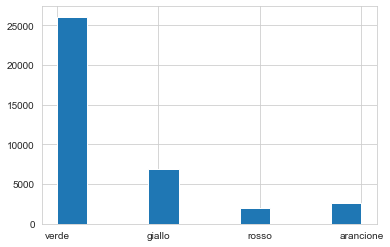

In [11]:
df.Rating.hist()

In [12]:
df.Rating.value_counts(normalize=True)

verde        0.692542
giallo       0.183774
arancione    0.069589
rosso        0.054095
Name: Rating, dtype: float64

In [13]:
df.Rating.value_counts()

verde        26104
giallo        6927
arancione     2623
rosso         2039
Name: Rating, dtype: int64

In [14]:
col         = 'Rating'
conditions  = [ (df[col] == 'giallo') | (df[col] == 'rosso') | (df[col] == 'arancione'), df[col] == 'verde']
choices     = [ 'rosso', 'verde' ] 
    
df[col] = np.select(conditions, choices, default=np.nan)

df.head()

,ID,Title,Rating,Author,Date,Chapter,Text,N_Rev
1,2909917,Rilassati! Hai tutta la morte davanti!,verde,Tonks98,2014-11-15 00:00:00+00:00,1,"""Zi zieda, prego. Allora, quale ezzere zuo ""B...",3
4,1390250,Episodi della Old Generation 1.,verde,mrsreg,2012-11-17 00:00:00+00:00,1,Introduzione. Personaggi: Argus Gazza:...,0
5,1143283,In Noctem,verde,LilacLilium,2012-04-07 00:00:00+00:00,1,Questo mio piccolo lavoretto è ispirato a una ...,2
7,917615,Dirty flower.,verde,Rue,2012-07-01 00:00:00+00:00,1,"DIRTY FLOWER. Lo hai sempre saputo, Lily. ...",3
8,917635,Hawthorn and Unicorn Air,rosso,Tonna,2012-08-01 00:00:00+00:00,1,Before you read: Bentro...,4


<AxesSubplot:>

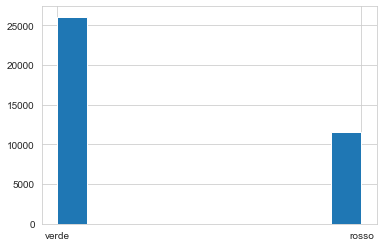

In [15]:
df.Rating.hist()

In [16]:
df.Rating.value_counts()

verde    26104
rosso    11589
Name: Rating, dtype: int64

In [17]:
df.Rating.value_counts(normalize=True)

verde    0.692542
rosso    0.307458
Name: Rating, dtype: float64

In [18]:
target = df[['Rating']]
del df['Rating']

In [19]:
from sklearn.model_selection import train_test_split, RepeatedKFold

#split on train-test 
x_train, x_test, y_train, y_test = train_test_split(df, target, test_size=0.30, random_state=42, stratify=target, shuffle=True) 

In [20]:
print(f"Train set size: {len(x_train)}\nTest set size: {len(x_test)}")

Train set size: 26385
Test set size: 11308


# Preprocessing

## Feature extraction with nltk and spacy

In [13]:
#!python -m spacy download it_core_news_sm

In [21]:
import nltk
import spacy
import re
nlp = spacy.load('it_core_news_sm')

doc_counter = 0
def reset_counter():
  global doc_counter
  doc_counter = 0

def increase_counter():
  global doc_counter
  doc_counter += 1
  if doc_counter % 100 == 0:
    print(doc_counter)

def spacy_nlp_tokenizer(text):
    increase_counter()

    # substituting all space characters with a single space
    text = re.sub('\s+', ' ', text)

    # we use spacy for main nlp tasks
    doc = nlp(text)
    # lemmatized tokens, skipping stopwords
    lemmas = ['LEMMA_'+token.lemma_ for token in doc if not token.is_stop]
    # entity_types
    entity_types = ['NER_'+token.ent_type_ for token in doc if token.ent_type_]

    # in case an entity linker is available, we can use it do put actual entities as
    # features, e.g. Queen Elizabeth, Elizabeth II, Her Majesty -> KB2912
    # see https://spacy.io/usage/training#entity-linker
    # entities = ['ENT_'+token.ent_kb_id_ for token in doc if token.ent_kb_id_]

    # we use a simple nltk function to create ngrams
    lemma_bigrams = ['BI_'+p1+'_'+p2 for p1,p2 in nltk.ngrams(lemmas,2)]
    lemma_trigrams = ['TRI_'+p1+'_'+p2+'_'+p3 for p1,p2,p3 in nltk.ngrams(lemmas,3)]

    all_tokens = list()
    all_tokens.extend(lemmas)
    all_tokens.extend(lemma_bigrams)
    all_tokens.extend(lemma_trigrams)
    all_tokens.extend(entity_types)
    return all_tokens

In [22]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

### Tokenization 

In [24]:
#vect = CountVectorizer(analyzer=spacy_nlp_tokenizer, min_df=5)  
#reset_counter()
#X_train_tok = vect.fit_transform(x_train.Racconto_Text_Only)
#reset_counter()
#X_test_tok = vect.transform(x_test.Racconto_Text_Only)

In [25]:
#with open(path+r'\Rating\x_train_tok.pkl','wb') as outfile:
#    pickle.dump(X_train_tok,outfile)
#with open(path+r'\Rating\x_test_tok.pkl','wb') as outfile:
#    pickle.dump(X_test_tok,outfile)
#with open(path+r'\Rating\vect.pkl','wb') as outfile:
#    pickle.dump(vect,outfile)

In [24]:
a_file = open(path+r"\Rating\x_train_tok.pkl", "rb")
X_train_tok = pickle.load(a_file)

b_file = open(path+r"\Rating\x_test_tok.pkl", "rb")
X_test_tok = pickle.load(b_file)

c_file = open(path+r"\Rating\vect.pkl", "rb")
vect = pickle.load(c_file)

In [25]:
print(f"Lunghezza del vocabolario: {len(vect.vocabulary_)}")

Lunghezza del vocabolario: 913760


In [26]:
#vect.vocabulary_

In [27]:
#vect.inverse_transform(X_train_tok[0,:])

# Rating Classification

In [28]:
rating_pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k=5000)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

reset_counter()
rating_pipeline.fit(X_train_tok,y_train.values.ravel())

reset_counter()
rating_predictions = rating_pipeline.predict(X_test_tok)

In [29]:
print('Classification report:')
print(classification_report(y_test, rating_predictions))
print('Confusion matrix:')
rating_cm = confusion_matrix(y_test, rating_predictions)
print(rating_cm)

Classification report:
              precision    recall  f1-score   support

       rosso       0.72      0.46      0.56      3477
       verde       0.79      0.92      0.85      7831

    accuracy                           0.78     11308
   macro avg       0.76      0.69      0.71     11308
weighted avg       0.77      0.78      0.76     11308

Confusion matrix:
[[1615 1862]
 [ 632 7199]]


## Optimization 

In [30]:
from sklearn.metrics import f1_score, recall_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

search_space = [{'sel__k': [10000, 100000, 250000, 500000, 'all'],
                 'learner':[MultinomialNB()],
                 'learner__alpha': [1e-3, 1e-2, 0.1, 1.0, 10.0],
                 'learner__fit_prior':[True, False]}, 
                {'sel__k': [10000, 100000, 250000, 500000, 'all'],
                 'learner':[LinearSVC()],
                 'learner__C': [0.01, 0.1, 1, 10, 100]},
                {'sel__k': [10000, 100000, 250000, 500000, 'all'], 
                 'learner':[LogisticRegression()],
                 'learner__solver':["liblinear"],
                 'learner__penalty' : ['l1', 'l2'],
                 'learner__C': [0.01, 0.1, 1, 10, 100]} 
               ]

rating_opt_pipeline = Pipeline([
#    ('vect', CountVectorizer()),  # feature extraction
    ('sel', SelectKBest(chi2)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

scoring = make_scorer(f1_score, greater_is_better=True, pos_label='rosso')

In [34]:
rating_opt_search = GridSearchCV(rating_opt_pipeline, 
                                 search_space,
                                 scoring = scoring,
                                 cv=3, n_jobs = -1, verbose=True).fit(X_train_tok,y_train.values.ravel())

Fitting 3 folds for each of 125 candidates, totalling 375 fits


C:\Users\chiar\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [35]:
rating_opt_search.best_params_

{'learner': MultinomialNB(alpha=0.01, fit_prior=False),
 'learner__alpha': 0.01,
 'learner__fit_prior': False,
 'sel__k': 250000}

In [36]:
rating_opt_search.cv_results_

{'mean_fit_time': array([ 10.00858347,  13.78289922,  15.39444447,  17.66776864,
         29.20883799,  11.12733928,  15.45294499,  14.49225752,
         17.50299398,  22.09736443,   9.90248728,  10.74764347,
         12.06622831,  16.55121994,  21.92073139,   9.61044788,
         10.72063669,  11.88081956,  14.80273851,  20.81448968,
          8.70260326,   8.92703279,  10.83496102,  13.68880916,
         19.72724732,   7.60755181,   8.7772944 ,  10.45825092,
         15.32106694,  22.24480216,   7.54649067,   8.80388745,
         10.34566021,  16.37268996,  23.01634685,   8.48693117,
          9.09402363,  10.73245494,  15.81460182,  20.29464293,
          7.22911453,   8.57145747,   9.7401921 ,  13.98356303,
         18.84450277,   7.50490141,   7.82597558,   9.8975242 ,
         13.71425811,  20.03053236,   8.74388353,  10.69234697,
         11.3403302 ,  19.17591015,  27.51566172,   9.25406218,
         11.48793316,  14.30746802,  22.37292878,  28.93068608,
         12.86830886,  

In [37]:
rating_opt_search.best_estimator_

Pipeline(steps=[('sel',
                 SelectKBest(k=250000,
                             score_func=<function chi2 at 0x0000015F4877DD30>)),
                ('tfidf', TfidfTransformer()),
                ('learner', MultinomialNB(alpha=0.01, fit_prior=False))])

In [31]:
model_opt_pipeline = Pipeline([
#    ('vect', CountVectorizer()),  # feature extraction
    ('sel', SelectKBest(chi2, k=250000)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', MultinomialNB(alpha=0.01, fit_prior=False))  # learning algorithm
])

In [ ]:
#rating_opt_predictions = rating_opt_search.best_estimator_.predict(X_test_tok)

reset_counter()
model_opt_pipeline.fit(X_train_tok, y_train.values.ravel())

reset_counter()
rating_opt_predictions = model_opt_pipeline.predict(X_test_tok)

In [33]:
print('Classification report:')
print(classification_report(y_test, rating_opt_predictions))
print('Confusion matrix:')
rating_opt_cm = confusion_matrix(y_test, rating_opt_predictions)
print(rating_opt_cm)

Classification report:
              precision    recall  f1-score   support

       rosso       0.58      0.60      0.59      3477
       verde       0.82      0.81      0.81      7831

    accuracy                           0.75     11308
   macro avg       0.70      0.71      0.70     11308
weighted avg       0.75      0.75      0.75     11308

Confusion matrix:
[[2093 1384]
 [1496 6335]]


## Inspecting the Pipeline

In [44]:
rating_tokenizer = vect
rating_selector = model_opt_pipeline.named_steps['sel']
rating_classifier = model_opt_pipeline.named_steps['learner']

In [50]:
ratio = rating_classifier.feature_log_prob_[0]/rating_classifier.feature_log_prob_[1]

In [52]:
feats_w_classifier_weight = list()
feature_names = rating_tokenizer.get_feature_names()
for index,weight in enumerate(rating_selector.inverse_transform([ratio])[0]):
    if weight!=0:
        feats_w_classifier_weight.append((weight,feature_names[index]))
feats_w_classifier_weight = sorted(feats_w_classifier_weight)
len(feats_w_classifier_weight)

250000

In [56]:
feats_w_classifier_weight[-100::-1]

[(1.3017309251150995, 'BI_LEMMA___LEMMA_Falsa'),
 (1.3017309251150995, 'BI_LEMMA_Pista_LEMMA__'),
 (1.3017309251150995, 'BI_LEMMA_Falsa_LEMMA_Pista'),
 (1.301483212809652, 'BI_LEMMA_lo_LEMMA_film'),
 (1.3010486307484186, 'BI_LEMMA_!_LEMMA_-.-'),
 (1.3010093850598314, 'BI_LEMMA_So_LEMMA_Harry'),
 (1.3010051307924173, 'LEMMA_Ninna'),
 (1.3010048205461264, 'BI_LEMMA_tanto_LEMMA_regalo'),
 (1.3006262567155729, 'BI_LEMMA_alberare_LEMMA_”'),
 (1.300449540878736, 'BI_LEMMA_»_LEMMA_Angolo'),
 (1.3001666748540273, 'TRI_LEMMA_invitare_LEMMA_Fleur_LEMMA_ballare'),
 (1.3001666748540273, 'BI_LEMMA_Fleur_LEMMA_ballare'),
 (1.300033346196739, 'LEMMA_Elsa'),
 (1.2999557323865987, 'BI_LEMMA_._LEMMA_Lanciata'),
 (1.2996652415874215, 'TRI_LEMMA_giudizio_LEMMA_personale_LEMMA_:'),
 (1.2996344995246103, 'TRI_LEMMA_IMPORTANTE_LEMMA_,_LEMMA_AMICO'),
 (1.2996344995246103, 'TRI_LEMMA_DAVVERO_LEMMA_IMPORTANTE_LEMMA_,'),
 (1.2996344995246103, 'TRI_LEMMA_,_LEMMA_AMICO_LEMMA_...'),
 (1.2996344995246103, 'BI_LEMMA_

In [54]:
feats_w_classifier_weight[:100]

[(0.6455440460709427, 'LEMMA_clitoride'),
 (0.6507442391765524, 'BI_LEMMA_erezione_LEMMA_,'),
 (0.6577413951917751, 'BI_LEMMA_lo_LEMMA_orgasmo'),
 (0.658896060011362, 'BI_LEMMA_capezzolo_LEMMA_.'),
 (0.662554994996594, 'LEMMA_capezzolo'),
 (0.6628867266074101, 'LEMMA_erezione'),
 (0.6735282059171619, 'LEMMA_PV'),
 (0.6739484469266507, 'LEMMA_Erotico'),
 (0.6763868888792137, 'BI_LEMMA_(_LEMMA_PV'),
 (0.6802372089003575, 'LEMMA_lubrificare'),
 (0.6816054711946514, 'BI_LEMMA_capezzolo_LEMMA_turgido'),
 (0.6835595726467507, 'BI_LEMMA_il_LEMMA_capezzolo'),
 (0.6906842574498303, 'BI_LEMMA_lo_LEMMA_erezione'),
 (0.6920495888109893, 'BI_LEMMA_il_LEMMA_testicolo'),
 (0.6922104763110548, 'TRI_LEMMA_raggiungere_LEMMA_l’_LEMMA_orgasmo'),
 (0.6929203742142941, 'LEMMA_pube'),
 (0.6941991315072007, 'BI_LEMMA_l’_LEMMA_orgasmo'),
 (0.6943833225320659, 'BI_LEMMA_._LEMMA_Eterosessuale'),
 (0.696554992956624, 'BI_LEMMA_allargare_LEMMA_gamba'),
 (0.6970745528165665, 'BI_LEMMA_ritmare_LEMMA_spinto'),
 (0.69